In [1]:
import numpy as np
import scipy as sp
import ROOT
import matplotlib.pyplot as plt
from numpy.random import uniform, seed, binomial

from IPython.display import clear_output

seed(69420666)

%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
''' Read tree from file '''

dat_chain = ROOT.TChain("SystemTree")
dat_chain.Add("N1152704745.root")

N = dat_chain.GetEntries() # get number of events

In [3]:
''' Data histogram '''

ndf = 200 # number of bins (and degrees of freedom)

dat_hist = ROOT.TH1F("data_hist", "data histogram", ndf, 100, 800)

# fill out histogram

for entry in dat_chain:
    dat_hist.Fill(entry.x)
    
# data entries per bin of histogram (for chi squared)    

dat_bin_entries = [dat_hist.GetBinContent(i+1) for i in range(ndf)]

Info in <TCanvas::Print>: png file given_data_hist.png has been created


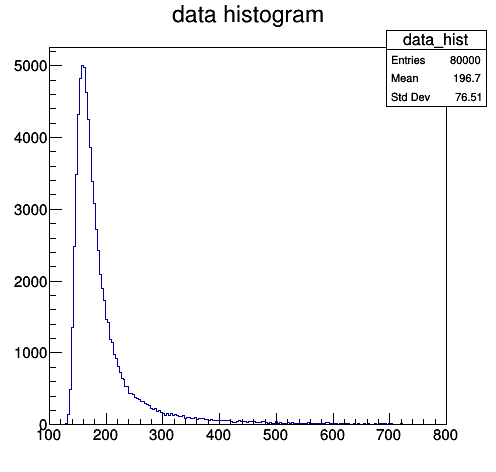

In [4]:
''' Plot histogram '''

c_draw = ROOT.TCanvas("c_draw", "histogram", 200, 50, 500, 500)
c_draw.SetFillColor(0)
dat_hist.Draw()
c_draw.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

c_draw.SaveAs("given_data_hist.png")

# Metropolis

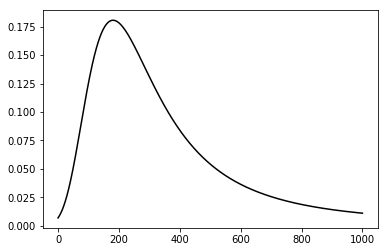

In [5]:
''' Roots Landau pdf: ROOT.TMath.Landau(x, mu, c, True), where the first three parameters are as 
    defined on the exam, and the boolean value determines if the PDF is normalized (True) or not (False)'''

# plot the Landau distribution using mu and c from histogram above

x_l = np.linspace(0,1000,10000)

mu_hist, c_hist = 197.7, 76.51

x_land = [ROOT.TMath.Landau(x, mu_hist, c_hist, False) for x in x_l]

plt.plot(x_l, x_land, '-k')

In [6]:
''' Mepropolis '''

def next_state(x_current, x_range, pdfArgs, pdf=ROOT.TMath.Landau):
    ''' Function that gets the new state given the current state, the domain, and the PDF of the system '''
    
    mu, c = pdfArgs # arguments for the Landau distribution as defined by the TMath class
    
    
    # generate a random possible state on the given range
    x_prime = uniform(low=x_range[0], high=x_range[1])
    
    
    delta_s = -1*np.log(pdf(x_prime, mu, c, True)/pdf(x_current, mu, c, True))
    
    if delta_s < 0:
        return x_prime

    else:

        p = pdf(x_prime, mu, c, True)/pdf(x_current, mu, c, True)

        accept = 0 if uniform(0,1)>p else 1

        return accept*x_prime + (1-accept)*x_current
    
    
def metropolis(x_0, x_range, N, mu, c):
    ''' Metropolis implementation. Calculates the N states of a system given the initial state, the domain of 
        the possible states, the number of states, and mu and c from the Landau distribution'''
    
    x = [x_0] # list that contains the succesive states of the system
                                                 # First state is taken from a uniform distribution on the 
                                                 # given domain
        
    for i in range(N-1):
        ''' Calculates the next 7999 states of the system by Metropolis algorithm '''
        x.append(next_state(x[i], x_range, [mu, c]))
        
    return x

In [7]:
''' Create states from mu and c of the histogram above '''

x_range = (100,800) # domain of the states. It is the same as the one taken on the histogram above

x_0 = uniform(low=x_range[0], high=[x_range[1]])

x_hist = metropolis(x_0, x_range, N, mu_hist, c_hist)

In [8]:
''' Histogram of the generated data by metropolis algorithm '''

metro_hist = ROOT.TH1F("metro_hist", "metropolis histogram", ndf, 100, 800)

# fill out histogram

for entry in x_hist:
    metro_hist.Fill(entry)

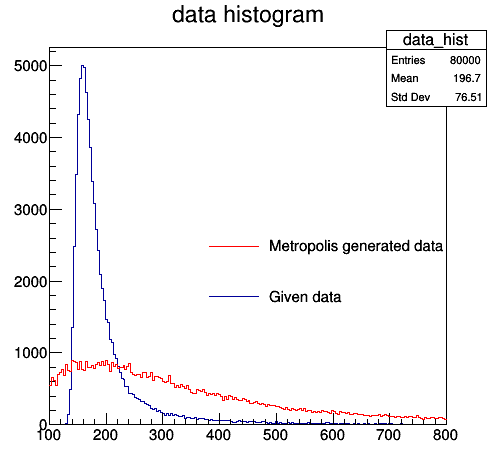

In [9]:
''' Histograms of metropolis generated data and given data '''

dat_hist.Draw()
metro_hist.Draw("Same")
metro_hist.SetLineColor(2)

leg = ROOT.TLegend(.4,.32,.97,.53)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.SetTextFont(42)
leg.SetTextSize(0.035)
leg.AddEntry(metro_hist,"Metropolis generated data","L")
leg.AddEntry(dat_hist,"Given data","L")
leg.Draw()

c_draw.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

# χ² parameter fitting

In [34]:
def chi_squared(dat, metro, ndf):
    ''' Chi-squared function as defined on the statement. 
    
        Note: if the data entry is cero, then a divition by
        zero would occur, resulting on an inf value. To avoid this, if dat = 0, then only the squared of the
        value of the metropolis generated data is considered: if this datum happens to be cero, it is considered
        to be a correct predicition, and will not contribute to the value of the chi-squated; if otherwise it is
        different from cero, then the value will contribute to the chi-squared.'''
    
    c_s = [(dat[i] - metro[i])**2 / dat[i] if dat[i] != 0 else metro[i] for i in range(ndf)]
    
    return np.sum(np.array(c_s))/ndf



def bins_from_hist(x):
    ''' gets the bins of a histogram generated with x data '''
    
    temp_hist = ROOT.TH1F("temp_hist", " temp data histogram", ndf, 100, 800)

    # fill out histogram

    for entry in x:
        temp_hist.Fill(entry)
    
    # data entries per bin of histogram (for chi squared)    

    return [temp_hist.GetBinContent(i+1) for i in range(ndf)]    

In [35]:
''' Determination of the minimum chi squared by sweeping alog mu ans c parameters over an interval '''

mu_int = np.linspace(mu_hist-50, mu_hist+50, 100) # mu interval
c_int = np.linspace(0.1, c_hist+100, 100) # c interval


# range and initial state to generate data of every

x_minchi_range = (100,800)
x_minchi_0 = uniform(low=x_minchi_range[0], high=[x_minchi_range[1]])


# array with the chi squared values over the mu-c space

chi_space = np.zeros((100,100))

min_chi = np.inf # chi squared minimum value
i_min, j_min = 0,0 # position of chi squared min value on chi_space

for i in range(100):
    for j in range(100):
        print("Minimum so far at i: {} j: {}. Currently at i: {} j: {}".format(i_min,j_min,i,j))
        
        # bin entries of metro generated data              
        metro_bin_entries = bins_from_hist(metropolis(x_0, x_range, N, mu_int[i], c_int[j]))
    
        # chi squared calculation
        chi_space[i,j] = chi_squared(dat_bin_entries, metro_bin_entries, ndf)
        
        print(chi_space[i,j])
        
        if chi_space[i,j] < min_chi:
            i_min, j_min = i, j
            min_chi = chi_space[i,j]
              
        clear_output()


Minimum X^2/ndf at mu = 160.831313131 c = 10.7915151515 with X^2/ndf = 7.32526457761


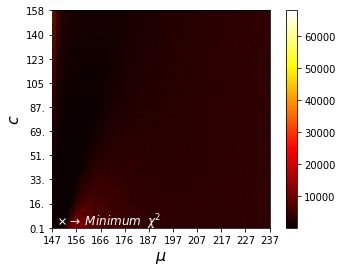

In [51]:
''' Plot (color map) of the calculated chi squared '''


#save the array of calculated chi squareds
np.save("chi_space.npy",chi_space)

fig, ax = plt.subplots()

c = ax.imshow(chi_space, cmap="hot")
fig.colorbar(c)

ax.set_xticks(np.arange(0,100,10))
ax.set_yticks(np.arange(0,100,10))

ax.set_xlim(0,90)
ax.set_ylim(0,90)

mu_ticklables, c_ticklabels = [str(mu_int[0])[:3]],[str(c_int[0])[:3]]

count = 1

for mu,c in zip(mu_int, c_int):
    if count%10==0:
        mu_ticklables.append(str(mu)[:3])
        c_ticklabels.append(str(c)[:3])
    
    count += 1
ax.set_xticklabels(mu_ticklables)
ax.set_yticklabels(c_ticklabels)

ax.plot(4,3,'xw')

ax.set_xlabel(r"$\mu$",fontsize=16)
ax.set_ylabel(r"$c$",fontsize=16)

ax.text(6,1,r"$ \rightarrow \; Minimum \; \; \chi^{2}$",color="white",fontsize=12)

fig.savefig("Chi_squared_plot.png", format="png")#,bbox_inches="Tight")

print("Minimum X^2/ndf at mu = {} c = {} with X^2/ndf = {}".format(mu_int[i_min], c_int[j_min], min_chi))

In [43]:
''' Create states from mu and c of minimum chi squared '''

x_range_chmin = (100,800)

mu_min = mu_int[i_min]
c_min = c_int[j_min]

print("Mu and c for minimum chi squared: {} {}".format(mu_min, c_min))

x_0_chmin = uniform(low=x_range_chmin[0], high=[x_range_chmin[1]])

x_chmin = metropolis(x_0_chmin, x_range_chmin, N, mu_min, c_min)

Mu and c for minimum chi squared: 160.831313131 10.7915151515


In [45]:
''' Histogram of the generated data by metropolis algorithm '''

metro_hist_min = ROOT.TH1F("metro_hist_min", "metropolis ans real data histograms", ndf, 100, 800)

# fill out histogram

for entry in x_chmin:
    metro_hist_min.Fill(entry)

Warning in <TROOT::Append>: Replacing existing TH1: metro_hist_min (Potential memory leak).


Info in <TCanvas::Print>: png file optimal_chi_hist.png has been created


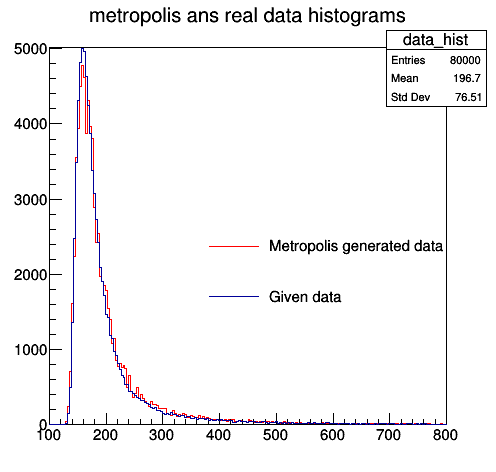

In [46]:
# draw histogram

metro_hist_min.Draw()
metro_hist_min.SetLineColor(2)
dat_hist.Draw("Same")

leg2 = ROOT.TLegend(.4,.32,.97,.53)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.SetFillStyle(0)
leg2.SetTextFont(42)
leg2.SetTextSize(0.035)
leg2.AddEntry(metro_hist_min,"Metropolis generated data","L")
leg2.AddEntry(dat_hist,"Given data","L")
leg2.Draw()

c_draw.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

c_draw.SaveAs("optimal_chi_hist.png")